In [26]:
import sys
from pathlib import Path
from collections import Counter

import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from yaml import safe_load
import matplotlib.pyplot as plt

In [2]:
dev_predictions = '../data/runs/joint_bert_classifier/dev_predictions.jsonl'
dev_input = '../data/deft_split/jsonl/dev.jsonl'
Path(dev_input).exists()

True

## Load the data

In [43]:
predictions_df = pd.read_json(dev_predictions, lines=True)
input_df = pd.read_json(dev_input, lines=True)
df = pd.DataFrame({
    'id': predictions_df['example_id'],
    'gold_tags': input_df['tags'],
    'predicted_tags': predictions_df['tags'],
    'gold_relations': input_df['relations'],
    'predicted_relations': predictions_df['relations'],
})
del predictions_df
del input_df
df.keys()

Index(['id', 'gold_tags', 'predicted_tags', 'gold_relations',
       'predicted_relations'],
      dtype='object')

In [34]:
assert len(df) == 711

In [6]:
config_path = Path('../data/deft_corpus/evaluation/program/configs/eval_test.yaml')
assert config_path.exists() and config_path.is_file(), 'Config not found'
with config_path.open() as cfg_file:
    config = safe_load(cfg_file)

In [38]:
# Utility functions
def flatten_list(valuelist):
    return [t for s in valuelist for t in s]

## Subtask 2 metrics

In [91]:
predicted_tags = flatten_list(df['predicted_tags'])
gold_tags = flatten_list(df['gold_tags'])

# Either use all labels or just the evaluated classes
task2_labels = config['task_2']['eval_labels']
#task2_labels = list(set(gold_tags).difference(set('O')))

In [92]:
assert len(predicted_tags) == len(gold_tags)

In [93]:
#Counter(gold_tags)

In [94]:
task2_report = classification_report(gold_tags, predicted_tags, labels=task2_labels, output_dict=True)
pd.DataFrame(task2_report).transpose()

,precision,recall,f1-score,support
B-Term,0.742402,0.736011,0.739193,697.0
I-Term,0.668546,0.709330,0.688334,836.0
B-Definition,0.662774,0.681682,0.672095,666.0
I-Definition,0.705939,0.821235,0.759235,8872.0
B-Alias-Term,0.360465,0.484375,0.413333,64.0
I-Alias-Term,0.580645,0.444444,0.503497,81.0
B-Referential-Definition,0.500000,0.500000,0.500000,18.0
I-Referential-Definition,0.484848,0.444444,0.463768,36.0
B-Referential-Term,0.333333,0.153846,0.210526,13.0
I-Referential-Term,0.400000,0.333333,0.363636,6.0


In [95]:
task2_confusion = confusion_matrix(gold_tags, predicted_tags, labels=task2_labels)
task2_confusion_df = pd.DataFrame(task2_confusion)
task2_confusion_df.set_axis(task2_labels, axis=1, inplace=True)
task2_confusion_df.set_axis(task2_labels, axis=0, inplace=True)
task2_confusion_df

,B-Term,I-Term,B-Definition,I-Definition,B-Alias-Term,I-Alias-Term,B-Referential-Definition,I-Referential-Definition,B-Referential-Term,I-Referential-Term,B-Qualifier,I-Qualifier
B-Term,513,10,1,25,14,0,0,0,0,0,0,1
I-Term,2,593,0,28,1,4,0,0,0,0,0,0
B-Definition,4,0,454,50,0,0,0,2,0,0,0,3
I-Definition,5,10,25,7286,4,3,0,5,0,0,0,2
B-Alias-Term,11,1,0,8,31,0,0,0,0,0,0,0
I-Alias-Term,0,22,0,5,3,36,0,0,0,0,0,0
B-Referential-Definition,0,0,2,2,0,0,9,0,0,0,0,0
I-Referential-Definition,0,0,0,15,0,0,0,16,0,0,0,0
B-Referential-Term,0,0,0,0,0,0,0,0,2,0,0,0
I-Referential-Term,0,0,0,0,0,0,0,0,0,2,0,0


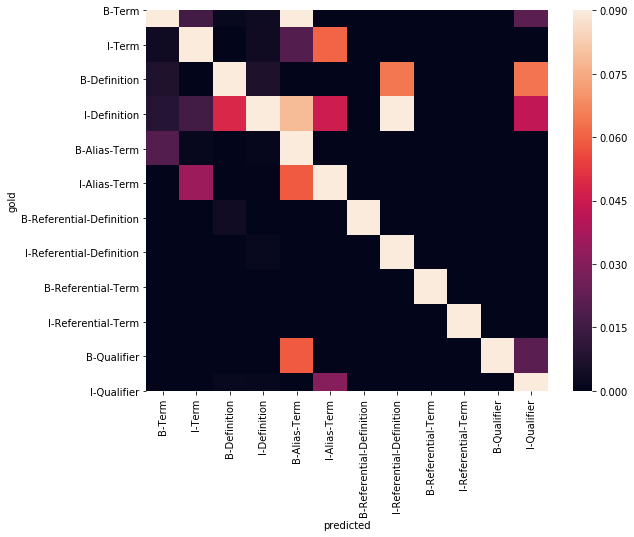

In [96]:
plt.figure(figsize=(9, 7))
ax = sns.heatmap(task2_confusion_df/task2_confusion_df.sum(axis=1), vmax=.09)  # Normalized
#ax = sns.heatmap(confusion_df, vmax=5)
ax.set(xlabel='predicted', ylabel='gold')
ax

## Subtask 3 metrics (token-level)

In [44]:
predicted_relations = flatten_list(df['predicted_relations'])
gold_relations = flatten_list(df['gold_relations'])
task3_labels = config['task_3']['eval_labels']

In [54]:
print(classification_report(gold_relations, predicted_relations))

                  precision    recall  f1-score   support

               0       0.92      0.92      0.92     35966
             AKA       0.56      0.38      0.45       141
  Direct-Defines       0.71      0.76      0.73      8271
Indirect-Defines       0.68      0.32      0.44       220
       Refers-To       0.00      0.00      0.00        11
     Supplements       0.26      0.12      0.17       953
        fragment       0.00      0.00      0.00       110

        accuracy                           0.87     45672
       macro avg       0.45      0.36      0.39     45672
    weighted avg       0.86      0.87      0.86     45672



In [46]:
task3_report = classification_report(gold_relations, predicted_relations, labels=task3_labels, output_dict=True)
pd.DataFrame(task3_report).transpose()

/home/marc/Applications/miniconda3/envs/semeval_2020_task_6/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marc/Applications/miniconda3/envs/semeval_2020_task_6/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,precision,recall,f1-score,support
Direct-Defines,0.708884,0.759279,0.733217,8271.0
Indirect-Defines,0.676190,0.322727,0.436923,220.0
AKA,0.556701,0.382979,0.453782,141.0
Refers-To,0.000000,0.000000,0.000000,11.0
Qualifies,0.000000,0.000000,0.000000,0.0
micro avg,0.706876,0.741062,0.723565,8643.0
macro avg,0.388355,0.292997,0.324784,8643.0
weighted avg,0.704667,0.741062,0.720183,8643.0


In [67]:
#task3_confusion_df = pd.DataFrame(confusion_matrix(gold_relations, predicted_relations))
task3_confusion_df = pd.DataFrame(confusion_matrix(gold_relations, predicted_relations, labels=task3_labels))
task3_confusion_df.set_axis(task3_labels, axis=1, inplace=True)
task3_confusion_df.set_axis(task3_labels, axis=0, inplace=True)
task3_confusion_df

,Direct-Defines,Indirect-Defines,AKA,Refers-To,Qualifies
Direct-Defines,6280,0,0,0,0
Indirect-Defines,30,71,0,0,0
AKA,7,0,54,0,0
Refers-To,5,0,0,0,0
Qualifies,0,0,0,0,0


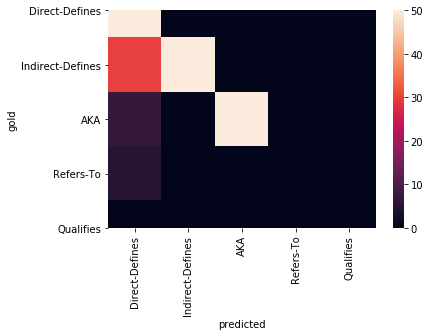

In [106]:
#plt.figure(figsize=(9, 7))
#ax = sns.heatmap(task3_confusion_df/task3_confusion_df.sum(axis=1), vmax=.008)  # Normalized
ax = sns.heatmap(task3_confusion_df, vmax=50)
ax.set(xlabel='predicted', ylabel='gold')
ax

### Hypothesis
 * the models struggle to detect coreference?
   * For the cases of an indirect-defines relation: Check if the model correctly predicts a direct-defines if the coreference is resolved. This would mean, that the model struggles to detect the referring term/definition instead of detecting the "defines pattern".
   * Are the cases with confused direct-defines and indirect-defines also missing a correct refers-to relation?
 * models get distracted from long sentences/context
   * Strip away the irrelevant sentences (without annotations)
   * Shorten the sentences to the core
 * the models extract simple linguistic features
   * replace ner tags by placeholders and count the occurrences of unique strings
   * count the numbers by gold label (this is probably not so easy because there might be multiple relations per example)
   * test the models on a difficult part of the WCL dataset?
 * the model uses the linguistic style of the description tokens (many articles etc.)
   * Use allennlp interpret to come up with a first glance on this

### errudite remarks
 * Do not solely focus on errors but also on sucessful predictions
    * distractor hypothesis (entity distractor example)
 * Check the coverage of the analysis (cover all of the data ideally)
 * make the analysis precise, reproducible and scalable (what exactly does this mean?)
   * define groups explicitly, i.e. "groups with sentences longer than 20 tokens"
 * Explicitly test hypotheses
   * Rewrite rules (Remove distractor example)
 * UI
   * Attribute distributions (e.g. entity type distribution in subset)
   * 

### potential ideas
 * tf-idf values of tokens
 * rarity of tokens
 * active vs. passive